In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import matplotlib.cm as cm
import numpy as np
import pickle
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Database Creation 

In [2]:
# File paths
stu_mat_path = "Resources/stu_mat.csv"
stu_por_path = "Resources/stu_por.csv"
db_path = "Resources/student_performance.db"

In [3]:
# Load CSV files
df_mat = pd.read_csv(stu_mat_path)
df_por = pd.read_csv(stu_por_path)

# Connect to SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

In [4]:
# Create tables if they do not exist
cursor.execute('''
CREATE TABLE IF NOT EXISTS student_mat (
    school TEXT, sex TEXT, age INTEGER, address TEXT, famsize TEXT,
    Pstatus TEXT, Medu INTEGER, Fedu INTEGER, Mjob TEXT, Fjob TEXT,
    reason TEXT, guardian TEXT, traveltime INTEGER, studytime INTEGER,
    failures INTEGER, schoolsup TEXT, famsup TEXT, paid TEXT, activities TEXT,
    nursery TEXT, higher TEXT, internet TEXT, romantic TEXT, famrel INTEGER,
    freetime INTEGER, goout INTEGER, Dalc INTEGER, Walc INTEGER, health INTEGER,
    absences INTEGER, G1 INTEGER, G2 INTEGER, G3 INTEGER
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS student_por (
    school TEXT, sex TEXT, age INTEGER, address TEXT, famsize TEXT,
    Pstatus TEXT, Medu INTEGER, Fedu INTEGER, Mjob TEXT, Fjob TEXT,
    reason TEXT, guardian TEXT, traveltime INTEGER, studytime INTEGER,
    failures INTEGER, schoolsup TEXT, famsup TEXT, paid TEXT, activities TEXT,
    nursery TEXT, higher TEXT, internet TEXT, romantic TEXT, famrel INTEGER,
    freetime INTEGER, goout INTEGER, Dalc INTEGER, Walc INTEGER, health INTEGER,
    absences INTEGER, G1 INTEGER, G2 INTEGER, G3 INTEGER
);
''')

In [5]:
# Insert data into tables (replace existing records)
df_mat.to_sql("student_mat", conn, if_exists="replace", index=False)
df_por.to_sql("student_por", conn, if_exists="replace", index=False)

# Commit and close connection
conn.commit()
conn.close()

# How does the educational background of parents influence the academic performance of students in final exams, as well as their interest in pursuing higher education? Specifically, do students whose parents have higher levels of education (e.g., secondary education or higher) perform better in their final exams compared to those whose parents have lower levels of education? Additionally, do students from higher-educated families demonstrate a stronger interest in pursuing higher education themselves? 


In [6]:
# Loading data from SQLite DB
sqlite_db_path = "Resources/student_performance.db"
conn = sqlite3.connect(sqlite_db_path)

In [7]:
conn = sqlite3.connect(sqlite_db_path)
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query_tables, conn)
print(tables)

          name
0  student_mat
1  student_por


In [8]:
# Query to fetch data from two tables
query_mat = "SELECT * FROM student_mat"
df_mat = pd.read_sql(query_mat, conn)

query_por = "SELECT * FROM student_por"
df_por = pd.read_sql(query_por, conn)

In [9]:
# Combining the two datasets
df = pd.concat([df_mat, df_por], ignore_index=True)
conn.close()

print("Loaded Data Preview (Merged Student Data):")
display(df.head())

Loaded Data Preview (Merged Student Data):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [10]:
# Data Preprocessing
df = df.dropna(subset=['G3'])  # Remove rows with missing final exam scores

# Encoding categorical features
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
# Normalizing numerical features (excluding grade columns)
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
grade_cols = ['G1', 'G2', 'G3']
numeric_cols = [col for col in numeric_cols if col not in grade_cols]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Feature Engineering
df['sudden_grade_drop'] = df['G1'] - df['G2']
df['attendance_engagement'] = df['absences'] / (df['G1'] + df['G2'] + df['G3'] + 1)
df['low_engagement_flag'] = (df['attendance_engagement'] > df['attendance_engagement'].quantile(0.75)).astype(int)

# Categorizing the final grades into three categories
def categorize_g3(grade):
    if grade < 10:
        return 0  # Low
    elif 10 <= grade < 15:
        return 1  # Medium
    else:
        return 2  # High

df['G3_category'] = df['G3'].apply(categorize_g3)

# Defining features and target variable
X = df.drop(columns=['G3', 'G3_category'])
y = df['G3_category']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
# Baseline Logistic Regression Model
log_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)

# Logistic Regression Model Evaluation
print("Logistic Regression Model Evaluation:")
print("Accuracy:", log_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_log))

C:\Users\mende\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Model Evaluation:
Accuracy: 0.8755980861244019
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        46
           1       0.89      0.90      0.89       122
           2       0.85      0.85      0.85        41

    accuracy                           0.88       209
   macro avg       0.87      0.86      0.86       209
weighted avg       0.88      0.88      0.88       209



In [12]:
# Baseline Decision Tree Model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)

# Decision Tree Model Evaluation
print("Decision Tree Model Evaluation:")
print("Accuracy:", tree_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))

Decision Tree Model Evaluation:
Accuracy: 0.8038277511961722
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        46
           1       0.84      0.82      0.83       122
           2       0.82      0.78      0.80        41

    accuracy                           0.80       209
   macro avg       0.79      0.79      0.79       209
weighted avg       0.81      0.80      0.80       209



In [13]:
# Drop rows with missing target values (G3, the final grade)
df = df.dropna(subset=['G3'])

# Encode categorical variables (e.g., parents' education level)
df['Medu_level'] = df['Medu'].apply(lambda x: 'None' if x == 0 else ('Primary' if x == 1 else ('Secondary' if x == 2 else 'Higher')))
df['Fedu_level'] = df['Fedu'].apply(lambda x: 'None' if x == 0 else ('Primary' if x == 1 else ('Secondary' if x == 2 else 'Higher')))

# Check if the target variable (final grade) has missing values
df['Medu_level'].value_counts(), df['Fedu_level'].value_counts()

(Medu_level
 Higher    1044
 Name: count, dtype: int64,
 Fedu_level
 Higher    1044
 Name: count, dtype: int64)

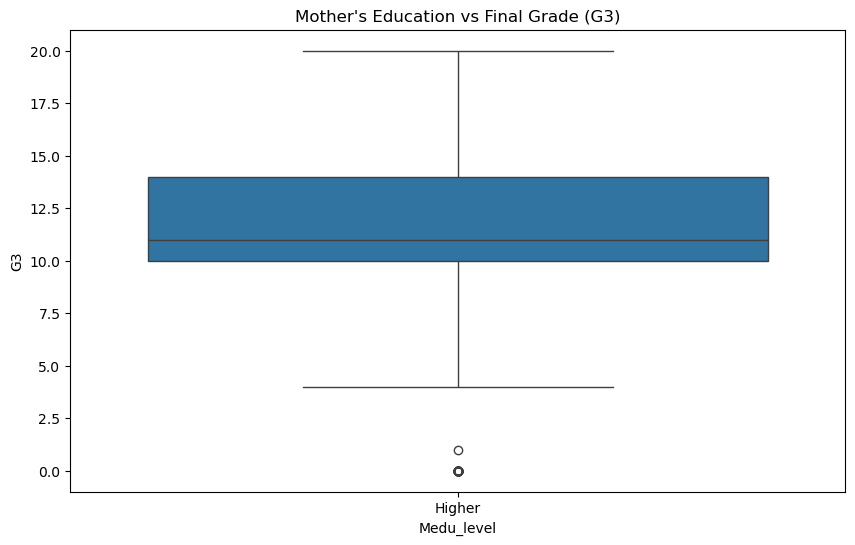

In [14]:
# Plotting the correlation between parental education and student performance
plt.figure(figsize=(10, 6))

# Plotting G3 vs Medu (Mother's education)
sns.boxplot(x='Medu_level', y='G3', data=df)
plt.title('Mother\'s Education vs Final Grade (G3)')

# Save the plot as an image (e.g., PNG)
plt.savefig('Visualizations/mother_education_vs_final_grade.png', dpi=300, bbox_inches='tight')

plt.show()

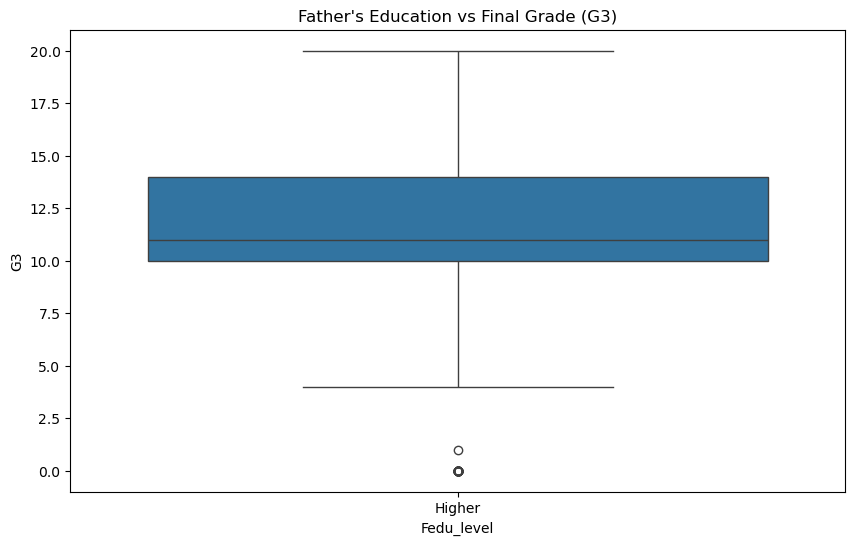

In [15]:
# Plotting G3 vs Fedu (Father's education)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fedu_level', y='G3', data=df)
plt.title('Father\'s Education vs Final Grade (G3)')

plt.savefig('Visualizations/Father\'s Education vs Final Grade.png', dpi=300, bbox_inches='tight')

plt.show()

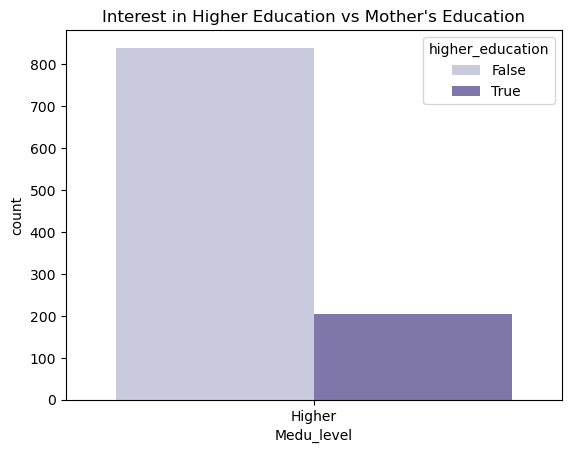

In [16]:
# Analyzing if students from higher-educated families are more likely to pursue higher education (assuming higher education is categorized in a binary format)
df['higher_education'] = df['G3'] >= 15  # assuming students with G3 >= 15 are considered as more likely to pursue higher education

# Plotting the data for students' interest in higher education based on parent's education level
# Create the figure and axis
fig, ax = plt.subplots()

# Create the countplot and assign the axis
sns.countplot(x='Medu_level', hue='higher_education', data=df, palette='Purples', ax=ax)

# Remove the background color
ax.set_facecolor('none')

# Set the title
plt.title("Interest in Higher Education vs Mother's Education")

# Save the plot
plt.savefig('Visualizations/Interest_in_Higher_Education_vs_Mother_Education.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

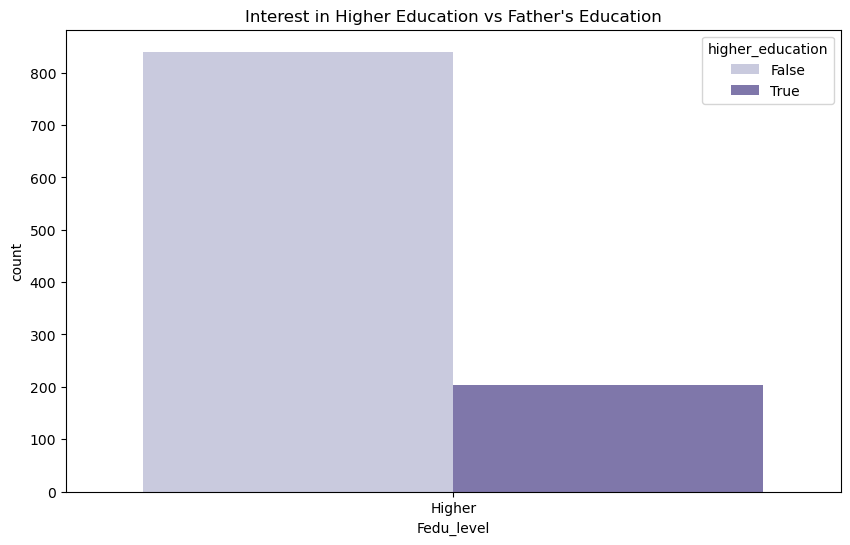

In [17]:
plt.figure(figsize=(10, 6), facecolor='none')  # Transparent background
ax = sns.countplot(x='Fedu_level', hue='higher_education', data=df, palette='Purples')

# Remove the background color
ax.set_facecolor('none')  # Makes the plot area transparent
plt.title("Interest in Higher Education vs Father's Education")

# Save with a transparent background
plt.savefig('Visualizations/Interest_vs_Father_Edu.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [18]:
# Encoding categorical features for modeling
df_encoded = pd.get_dummies(df[['Medu_level', 'Fedu_level', 'G1', 'G2', 'absences']], drop_first=True)

# Target variable: whether the student is interested in higher education (G3 >= 15)
y = (df['G3'] >= 15).astype(int)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)

# Logistic Regression Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Make predictions
y_pred_log = log_model.predict(X_test)

# Evaluate the Logistic Regression model
print("Logistic Regression Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:")
print(classification_report(y_test, y_pred_log))

Logistic Regression Model Evaluation:
Accuracy: 0.9712918660287081
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       166
           1       1.00      0.86      0.93        43

    accuracy                           0.97       209
   macro avg       0.98      0.93      0.95       209
weighted avg       0.97      0.97      0.97       209



In [19]:
# Decision Tree Model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Make predictions
y_pred_tree = tree_model.predict(X_test)

# Evaluate the Decision Tree model
print("Decision Tree Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))

Decision Tree Model Evaluation:
Accuracy: 0.9712918660287081
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       166
           1       1.00      0.86      0.93        43

    accuracy                           0.97       209
   macro avg       0.98      0.93      0.95       209
weighted avg       0.97      0.97      0.97       209



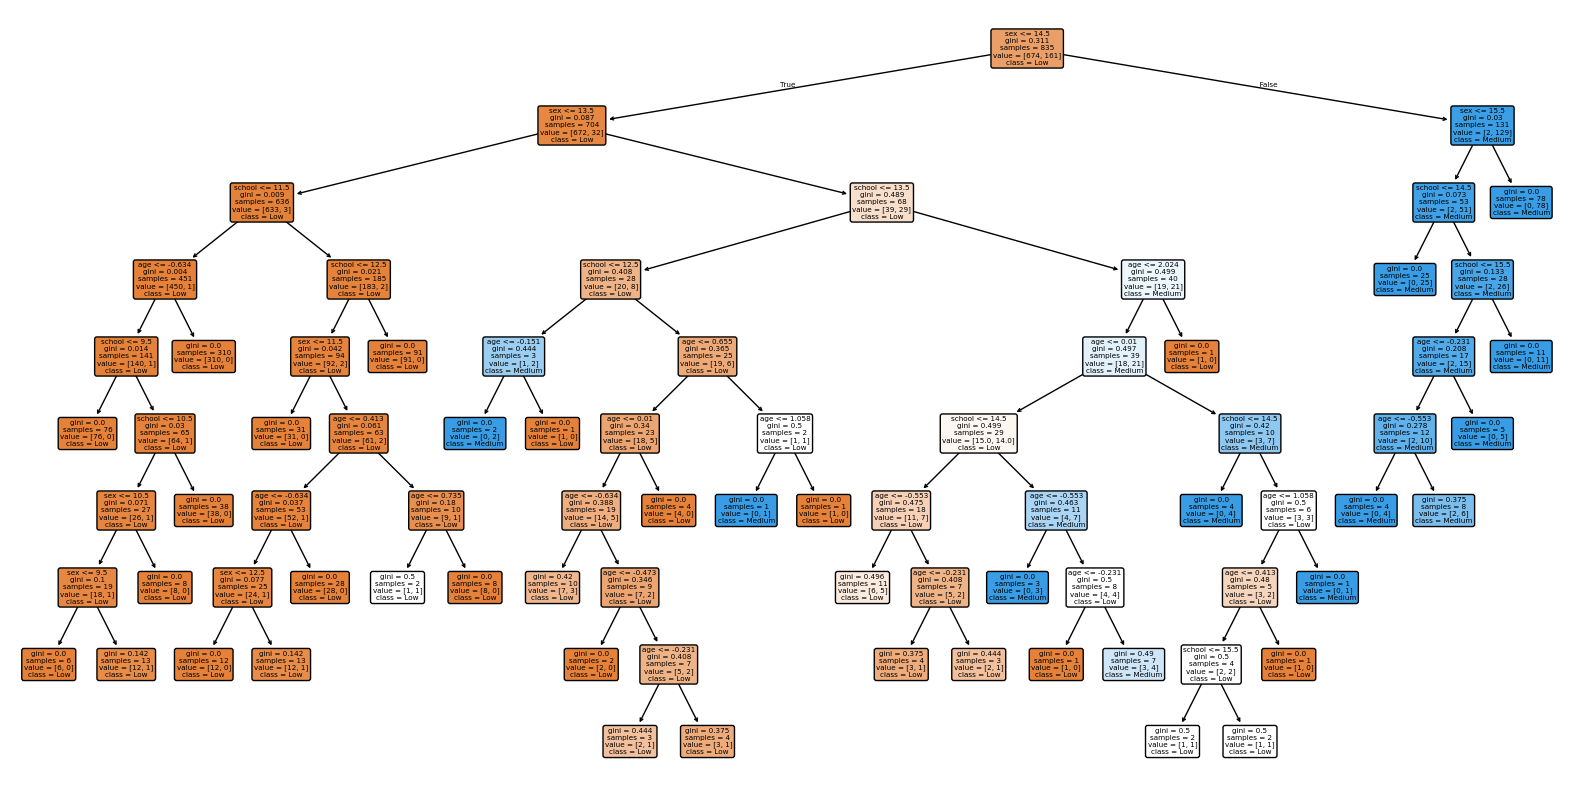

In [20]:
# Define the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# Remove the background color
ax.set_facecolor('none')  # Makes the plot area transparent

# Title for the plot
plt.title("Decision Tree Model for Predicting Student Outcomes")

# Plot the decision tree
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=['Low', 'Medium', 'High'], rounded=True)

# Save the decision tree plot as an image (e.g., PNG)
plt.savefig('Visualizations/decision_tree_plot.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

# What impact do certain social tendencies have on the students’ likelihood to succeed? (e.g. Frequency of alcoholic consumption, social lives, extracurricular activities, romantic relationships, etc.)

In [21]:
# Load the trained models
log_model = joblib.load("Resources/logistic_regression_model.pkl")
tree_model = joblib.load("Resources/decision_tree_model.pkl")
rf_model = joblib.load("Resources/random_forest_model.pkl")

print("Models loaded successfully")

Models loaded successfully


C:\Users\mende\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mende\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\mende\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.5.1. This mi

In [22]:
# Connect to SQLite database
sqlite_db_path = "Resources/student_performance.db"
conn = sqlite3.connect(sqlite_db_path)
df_mat = pd.read_sql("SELECT * FROM student_mat", conn)
df_por = pd.read_sql("SELECT * FROM student_por", conn)
df = pd.concat([df_mat, df_por], ignore_index=True)
conn.close()

# Display first few rows
print("Sample Data:")
display(df.head())

Sample Data:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [23]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df['sudden_grade_drop'] = df['G1'] - df['G2']
df['attendance_engagement'] = df['absences'] / (df['G1'] + df['G2'] + df['G3'] + 1)
df['low_engagement_flag'] = (df['attendance_engagement'] > df['attendance_engagement'].quantile(0.75)).astype(int)

X_analysis = df.drop(columns=['G3'])

# Predicting
df['Predicted_Performance_Log'] = log_model.predict(X_analysis)
df['Predicted_Performance_Tree'] = tree_model.predict(X_analysis)
df['Predicted_Performance_RF'] = rf_model.predict(X_analysis)

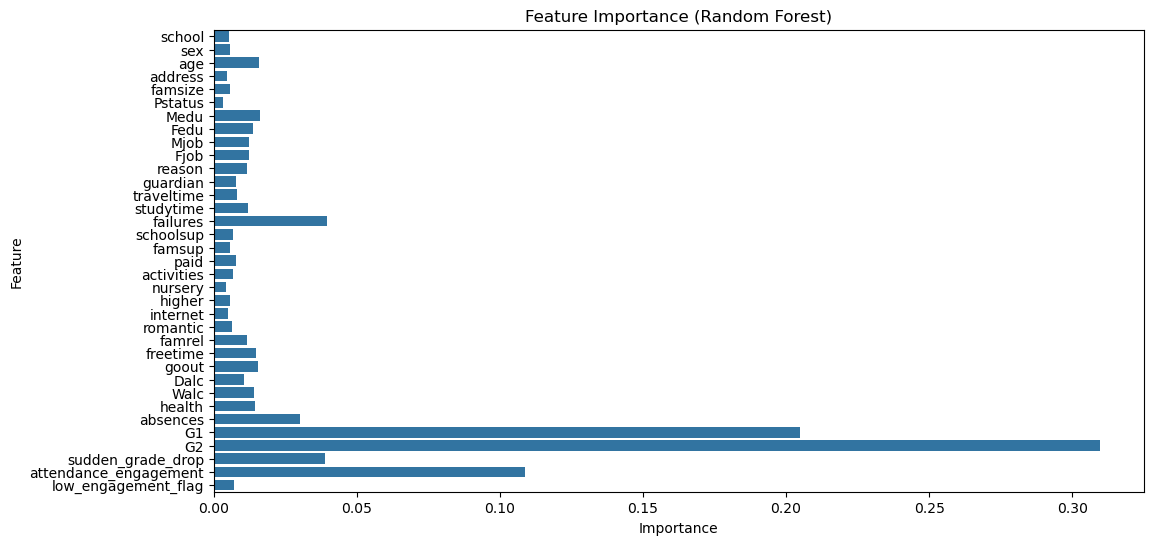

In [24]:
# Feature importance analysis
feature_importance = rf_model.feature_importances_
feature_names = X_analysis.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

C:\Users\mende\AppData\Local\Temp\ipykernel_25148\1846239627.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette=colors, edgecolor='black')
C:\Users\mende\AppData\Local\Temp\ipykernel_25148\1846239627.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=top_importances, y=top_features, palette=colors, edgecolor='black')


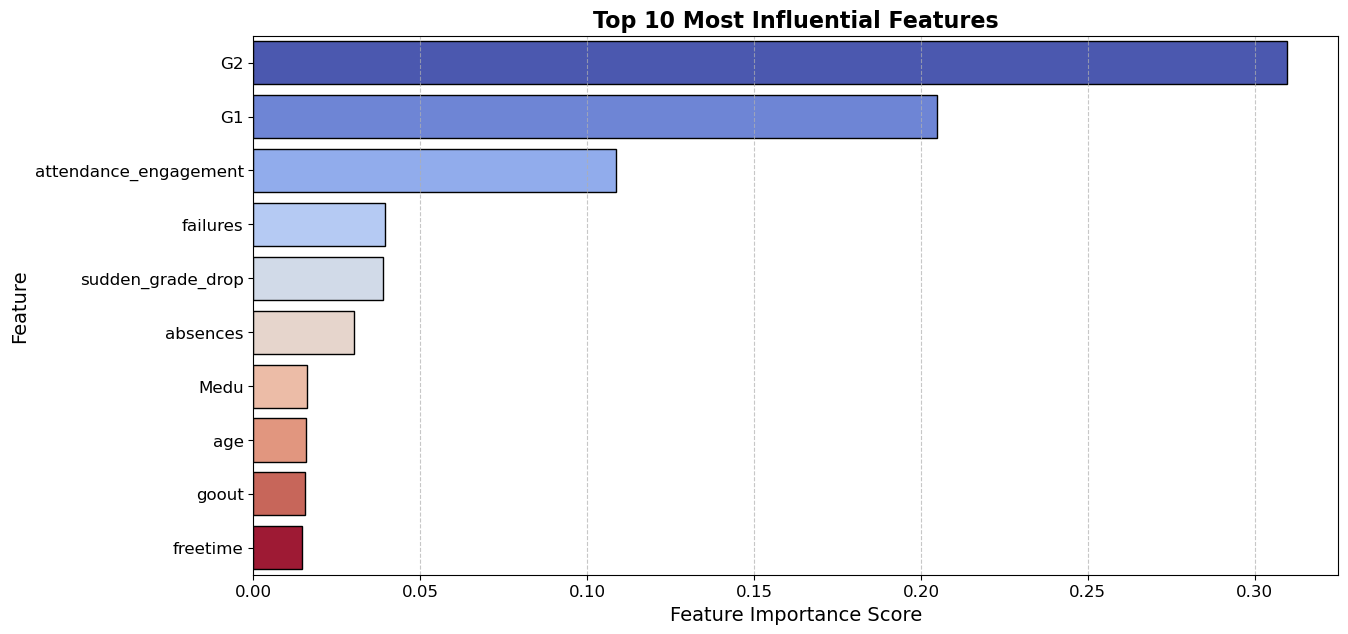

In [25]:
# Get feature importance values
feature_importance = rf_model.feature_importances_
feature_names = X_analysis.columns

# Sort feature importance in descending order and select top 10
sorted_idx = feature_importance.argsort()[::-1][:10]
top_features = [feature_names[i] for i in sorted_idx]
top_importances = feature_importance[sorted_idx]

# Plot the top 10 important features
plt.figure(figsize=(14, 7))
colors = cm.coolwarm(np.linspace(0, 1, len(top_features)))
sns.barplot(x=top_importances, y=top_features, palette=colors, edgecolor='black')
plt.title("Top 10 Most Influential Features", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

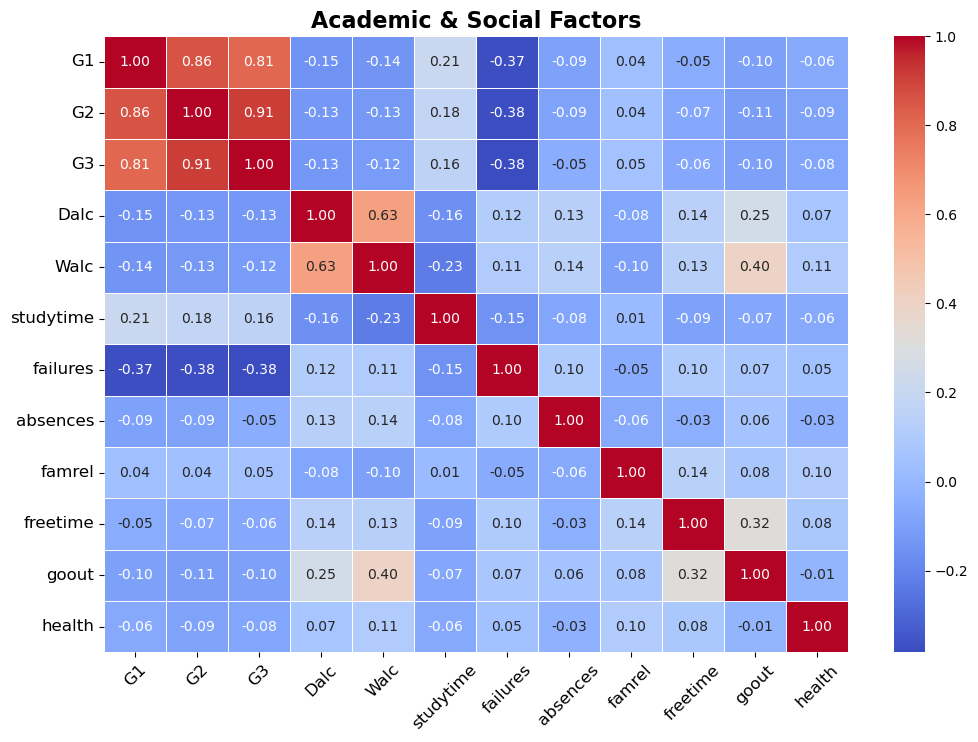

In [26]:
# correlation heatmap to analyze the relationships between acedemic and social factors
correlation_features = ['G1', 'G2', 'G3', 'Dalc', 'Walc', 'studytime', 'failures', 'absences', 'famrel', 'freetime', 'goout', 'health']
correlation_data = df[correlation_features]

# Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Academic & Social Factors", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

C:\Users\mende\AppData\Local\Temp\ipykernel_25148\4014016035.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['goout'], y=df['G3'], palette='coolwarm')


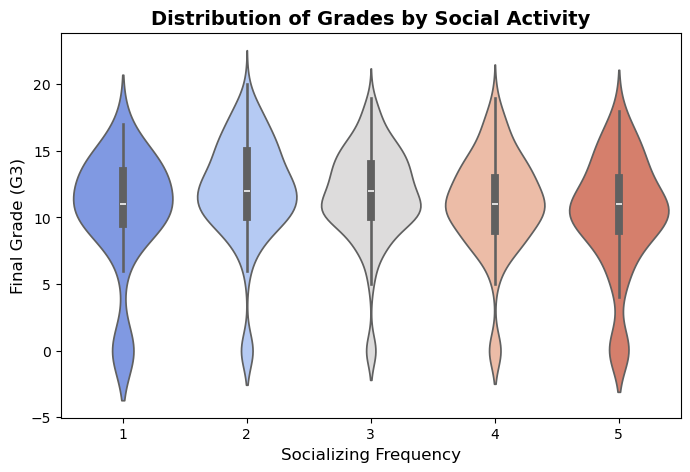

In [27]:
df_mat = pd.read_csv("Resources/stu_mat.csv")
df_por = pd.read_csv("Resources/stu_por.csv")
df = pd.concat([df_mat, df_por], ignore_index=True)

# Group socializing frequency into fewer bins for readability
df['G3'] = df['G3'].astype(int)  # Convert to integer for accuracy

# Violin plot with G3 from the original dataset
plt.figure(figsize=(8, 5))
sns.violinplot(x=df['goout'], y=df['G3'], palette='coolwarm')
plt.xlabel("Socializing Frequency", fontsize=12)
plt.ylabel("Final Grade (G3)", fontsize=12)
plt.title("Distribution of Grades by Social Activity", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [28]:
print(df['G3'].describe())

count    1044.000000
mean       11.341954
std         3.864796
min         0.000000
25%        10.000000
50%        11.000000
75%        14.000000
max        20.000000
Name: G3, dtype: float64


# Is there a relationship between a student being at-risk and access to extra educational support, family educational support, or extra paid classes within the course subject?


In [29]:
#loading db
sqlite_db_path = "Resources/student_performance.db"
conn = sqlite3.connect(sqlite_db_path)

query_mat = "SELECT * FROM student_mat"
df_mat = pd.read_sql(query_mat, conn)

query_por = "SELECT * FROM student_por"
df_por = pd.read_sql(query_por, conn)

# combining the two in the db
df = pd.concat([df_mat, df_por], ignore_index=True)

conn.close()

In [30]:
print("Loaded Data Preview (Merged Student Data):")
display(df.head())

df = df.dropna(subset=['G3'])

Loaded Data Preview (Merged Student Data):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [31]:
# encoding categorical features
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

## Optimization 1
### Logistic Regression accuracy 0.93
### Decision Tree accuracy  0.91

In [32]:
# # Optimization 1
# # Feature Engineering 
# df['school_support'] = df['schoolsup']
# df['family_support'] = df['famsup']

# # Calculate average grade
# df['average_grade'] = (df['G1']+df['G2']+df['G3']) / 3

# # Create multi-class labels to fit the linear model
# def categorize_g3(grade):
#     if grade < 10:
#         return 0  # Low
#     elif 10 <= grade < 15:
#         return 1  # Medium
#     else:
#         return 2  # High

# # Create a new column that contains the corresponding category for each grade
# df['G3_category'] = df['G3'].apply(categorize_g3)

# # Defining features and target variable
# X = df.drop(columns=['G3', 'G3_category'])
# y = df['G3_category']

# # Spliting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

## Optimization 2
### Logistic Regression accuracy 0.93
### Decision Tree accuracy  0.91

In [33]:
# Optimization 2
# Feature Engineering 
# for combined support
# df['famsup_schoolsup'] = df['famsup']*df['schoolsup']

# # Calculate average grade
# df['average_grade'] = (df['G1']+df['G2']+df['G3']) / 3

# # Create multi-class labels to fit the linear model
# def categorize_g3(grade):
#     if grade < 10:
#         return 0  # Low
#     elif 10 <= grade < 15:
#         return 1  # Medium
#     else:
#         return 2  # High

# # Create a new column that contains the corresponding category for each grade
# df['G3_category'] = df['G3'].apply(categorize_g3)

# # Defining features and target variable
# X = df.drop(columns=['G3', 'G3_category'])
# y = df['G3_category']

# # Spliting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# ) 

## Optimization 3
### Logistic Regression accuracy    0.93 
### Decision Tree accuracy  0.92

In [34]:
# # Feature Engineering
# # Support count
# df['support_count'] = df['famsup'] + df['schoolsup'] + df['paid']

# # Calculate average grade
# df['average_grade'] = (df['G1']+df['G2']+df['G3']) / 3

# # Create multi-class labels to fit the linear model
# def categorize_g3(grade):
#     if grade < 10:
#         return 0  # Low
#     elif 10 <= grade < 15:
#         return 1  # Medium
#     else:
#         return 2  # High

# # Create a new column that contains the corresponding category for each grade
# df['G3_category'] = df['G3'].apply(categorize_g3)

# # Defining features and target variable
# X = df.drop(columns=['G3', 'G3_category'])
# y = df['G3_category']

# # Spliting the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# ) 

## Optimization 4
### Logistic Regression accuracy    .99 
### Decision Tree accuracy  1.0

In [35]:
# Optimization 4
# Feature Engineering
# Study Time and Paid Support (these don't affect the accuracy)
# df['study_paid_interaction'] = df['paid'] * df['studytime']
# df['study_time_1'] = df['studytime'] < 2
# df['study_time_2'] = (df['studytime'] > 2) & (df['studytime'] < 5)
# df['study_time_3'] = (df['studytime'] > 5) & (df['studytime'] < 10)
# df['study_time_4'] = df['studytime'] > 10 

# Calculate average grade
df['average_grade'] = (df['G1']+df['G2']+df['G3']) / 3

# Create multiclass labels to fit the linear model
def categorize_g3(grade):
    if grade < 10:
        return 0    # At risk
    elif 10 <= grade < 12:
        return 1    # Moderate risk
    elif 12 <= grade < 15:
        return 2    # Low risk
    else:
        return 3    # Not at risk

# Create a new column that contains the corresponding category for each grade
df['risk_category'] = df['G3'].apply(categorize_g3)

# Defining features and target variable
X = df.drop(columns=['risk_category'])
y = df['risk_category']

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) 

In [36]:
# Baseline logistic regression model
log_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Model Evaluation:")
print("Accuracy:", log_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_log))

C:\Users\mende\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Model Evaluation:
Accuracy: 0.9904306220095693
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        46
           1       0.97      1.00      0.98        61
           2       1.00      1.00      1.00        61
           3       1.00      1.00      1.00        41

    accuracy                           0.99       209
   macro avg       0.99      0.99      0.99       209
weighted avg       0.99      0.99      0.99       209



C:\Users\mende\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
# baseline multi-class Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Model Evaluation:")
print("Accuracy:", tree_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))

Decision Tree Model Evaluation:
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        61
           3       1.00      1.00      1.00        41

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209



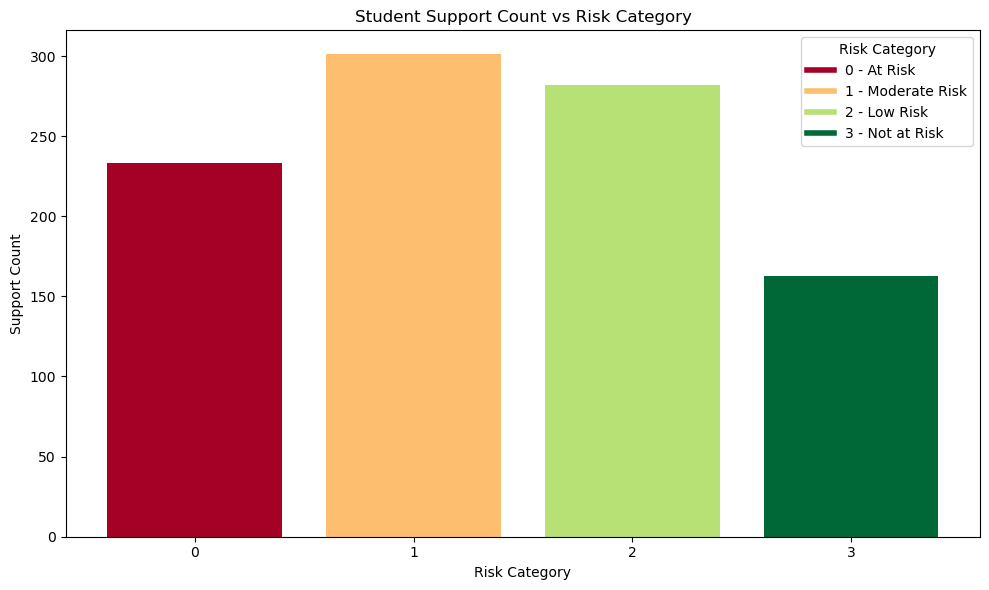

In [38]:
# Support Count vs Risk Category

# Count all forms of support
df['support_count'] = df['famsup'] + df['schoolsup'] + df['paid']

# Group by risk_category and sum the support_count
grouped_data = df.groupby('risk_category')['support_count'].sum().reset_index()

# Create chart
plt.figure(figsize=(10,6))

# Define colors based on risk category
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(grouped_data['risk_category'])))

# Create the bar chart with specificed colors
plt.bar(grouped_data['risk_category'], grouped_data['support_count'], color=colors)

plt.title('Student Support Count vs Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Support Count')

# If risk_category is numeric, ensure only whole numbers are displayed
if grouped_data['risk_category'].dtype in ['int64', 'float64']:
    plt.xticks(ticks=grouped_data['risk_category'], labels=grouped_data['risk_category'].astype(int))

# Create custom handles for the legend

handles = [
    plt.Line2D([0], [0], color=colors[0], lw=4, label='0 - At Risk'),  
    plt.Line2D([0], [0], color=colors[1], lw=4, label='1 - Moderate Risk'),
    plt.Line2D([0], [0], color=colors[2], lw=4, label='2 - Low Risk'),
    plt.Line2D([0], [0], color=colors[3], lw=4, label='3 - Not at Risk')
]

# Create a legend with custom labels only
plt.legend(handles=handles, title="Risk Category")
plt.tight_layout()
plt.show()

# How does health impact a person's likelihood succeed? Does poor health often result in more absences and poorer grades? Is there a high incidence of absence and failure among students classified in poor health? Is there a correlation between health and quality of family relationships?

In [39]:
#loading db
sqlite_db_path = "Resources/student_performance.db"
conn = sqlite3.connect(sqlite_db_path)


query_mat = "SELECT * FROM student_mat"
df_mat = pd.read_sql(query_mat, conn)

query_por = "SELECT * FROM student_por"
df_por = pd.read_sql(query_por, conn)

# combining the two in the db
df = pd.concat([df_mat, df_por], ignore_index=True)

# closing connection
conn.close()

In [40]:
print("Loaded Data Preview (Merged Student Data):")
display(df.head())

df = df.dropna(subset=['G3'])

Loaded Data Preview (Merged Student Data):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [41]:
# encoding categorical features (since sqlite doesn't play nice)
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalizing numerical features for future reference (further optimization)

scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
grade_cols = ['G1', 'G2', 'G3']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in grade_cols]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Compute correlation matrix using Spearman (handles ordinal data better)
correlation_matrix = df.corr(method='spearman')

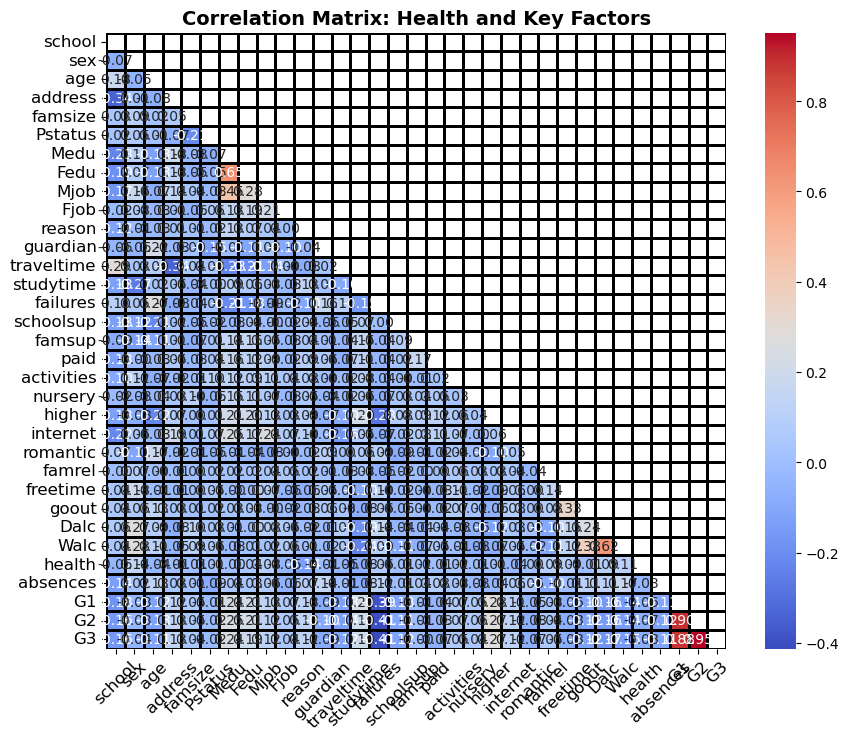

In [42]:
# Increase figure size for better readability
plt.figure(figsize=(10, 8))

# Use a mask to hide the upper triangle (optional, for clarity)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Adjust font size and layout
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=1,  # Adds spacing between cells
    linecolor="black", 
    annot_kws={"size": 10},  # Adjust text size
    mask=mask  # Optional: Mask the upper triangle to avoid repetition
)

plt.title("Correlation Matrix: Health and Key Factors", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, rotation=45)  # Rotate x-axis labels for better spacing
plt.yticks(fontsize=12)

plt.show()

In [43]:
# Compute Spearman correlations individually
health_abs_corr, p_abs = spearmanr(df['health'], df['absences'])
health_grade_corr, p_grade = spearmanr(df['health'], df['G3'])
health_famrel_corr, p_famrel = spearmanr(df['health'], df['famrel'])

# Display results
correlation_results = pd.DataFrame({
    "Variable": ["Health vs Absences", "Health vs Final Grade (G3)", "Health vs Family Relationships"],
    "Spearman Correlation": [health_abs_corr, health_grade_corr, health_famrel_corr],
    "P-value": [p_abs, p_grade, p_famrel]
})

In [44]:
# Print correlation results
print(correlation_results)

                         Variable  Spearman Correlation   P-value
0              Health vs Absences             -0.034380  0.267071
1      Health vs Final Grade (G3)             -0.080785  0.009017
2  Health vs Family Relationships              0.089701  0.003723


In [45]:
# Feature Engineering (first 3 metrics for what makes them at risk)
df['health_impact_score'] = (df['health'] * (df['G1'] + df['G2'] + df['G3'])) / (df['absences'] + 1)
df['health_absence_risk'] = ((df['health'] < 3) & (df['absences'] > df['absences'].quantile(0.75))).astype(int)
df['family_support'] = (df['famrel'] * (df['G1'] + df['G2'] + df['G3'])) / (df['absences'] + 1)

# Had to create multi-class labels to fit the linear model (this seamed better than binary good/bad)
def categorize_g3(grade):
    if grade < 10:
        return 0  # Low
    elif 10 <= grade < 15:
        return 1  # Medium
    else:
        return 2  # High

df['G3_category'] = df['G3'].apply(categorize_g3)

# Defining features and target variable
X = df.drop(columns=['G3', 'G3_category'])
y = df['G3_category']

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [46]:
# Load Logistic Regression model
with open('Resources/logistic_regression_model.pkl', 'rb') as file:
    model = pickle.load(file)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(predictions)

[0 1 1 1 1 1 1 2 2 2 1 2 2 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0
 0 1 1 2 1 2 1 2 0 1 1 0 1 1 1 1 0 0 2 1 2 1 0 1 1 0 2 1 1 1 1 2 2 1 1 2 2
 0 2 1 1 1 1 1 2 1 1 0 1 0 1 1 1 2 0 1 1 1 1 1 0 2 1 1 1 1 1 1 1 2 1 1 0 1
 1 1 1 1 0 1 1 1 2 1 0 2 1 1 2 1 1 0 2 1 1 2 2 1 1 1 2 1 2 1 1 1 2 2 0 1 2
 1 2 2 0 1 1 1 1 1 1 0 1 1 1 2 1 1 2 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 0 0 1 1 0 1 1 0 2 2 0 1 0 1 0 0 0]


C:\Users\mende\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
# # Baseline logistic regression model
log_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Model Evaluation:")
print("Accuracy:", log_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

C:\Users\mende\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Model Evaluation:
Accuracy: 0.8516746411483254
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        46
           1       0.87      0.88      0.87       122
           2       0.85      0.80      0.82        41

    accuracy                           0.85       209
   macro avg       0.84      0.84      0.84       209
weighted avg       0.85      0.85      0.85       209

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        46
           1       0.87      0.88      0.87       122
           2       0.85      0.80      0.82        41

    accuracy                           0.85       209
   macro avg       0.84      0.84      0.84       209
weighted avg       0.85      0.85      0.85       209



C:\Users\mende\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
# baseline multi-class Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Model Evaluation:")
print("Accuracy:", tree_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Decision Tree Model Evaluation:
Accuracy: 0.8229665071770335
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        46
           1       0.86      0.84      0.85       122
           2       0.89      0.78      0.83        41

    accuracy                           0.82       209
   macro avg       0.82      0.81      0.81       209
weighted avg       0.83      0.82      0.82       209

              precision    recall  f1-score   support

           0       0.70      0.83      0.76        46
           1       0.86      0.84      0.85       122
           2       0.89      0.78      0.83        41

    accuracy                           0.82       209
   macro avg       0.82      0.81      0.81       209
weighted avg       0.83      0.82      0.82       209



In [49]:
train_score_tree = tree_model.score(X_train, y_train)
test_score_tree = tree_model.score(X_test, y_test)

train_score_log = log_model.score(X_train, y_train)
test_score_log = log_model.score(X_test, y_test)

print(f"Decision Tree - Train: {train_score_tree}, Test: {test_score_tree}")
print(f"Logistic Regression - Train: {train_score_log}, Test: {test_score_log}")

Decision Tree - Train: 1.0, Test: 0.8229665071770335
Logistic Regression - Train: 0.9125748502994012, Test: 0.8516746411483254


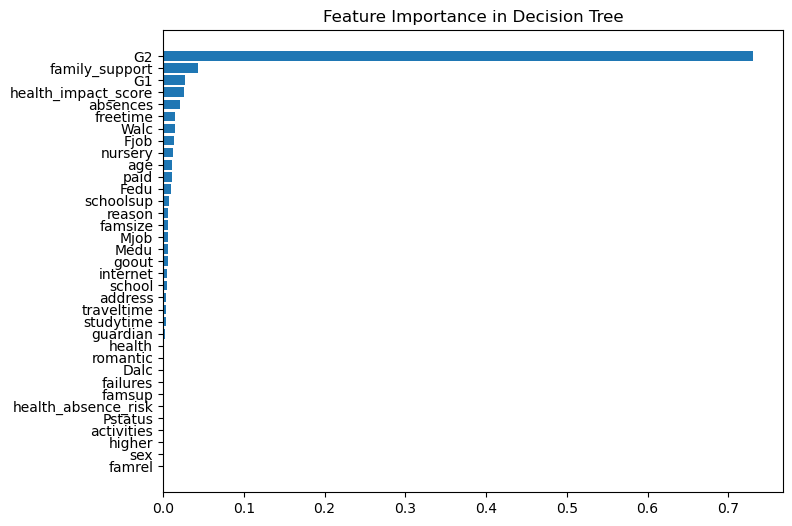

In [50]:
#Compare feature importance in decision tree
feature_importance = tree_model.feature_importances_
feature_names = X_train.columns

#Plot and show
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title("Feature Importance in Decision Tree")
plt.show()

In [51]:
# Prune the decision tree
pruned_tree_model = DecisionTreeClassifier(
    max_depth=5,  # Limits how deep the tree grows
    min_samples_split=10,  # Minimum 10 samples to split a node
    min_samples_leaf=5,  # Minimum 5 samples per leaf
    random_state=42
)

pruned_tree_model.fit(X_train, y_train)
y_pred_pruned = pruned_tree_model.predict(X_test)
pruned_tree_accuracy = accuracy_score(y_test, y_pred_pruned)

print("\nPruned Decision Tree Model Evaluation:")
print(f"Accuracy: {pruned_tree_accuracy:.4f}")
print(classification_report(y_test, y_pred_pruned))


Pruned Decision Tree Model Evaluation:
Accuracy: 0.8565
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        46
           1       0.86      0.90      0.88       122
           2       0.86      0.78      0.82        41

    accuracy                           0.86       209
   macro avg       0.86      0.83      0.84       209
weighted avg       0.86      0.86      0.86       209



In [52]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

rf_accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")

Random Forest Test Accuracy: 0.8469


<Figure size 600x600 with 0 Axes>

C:\Users\mende\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


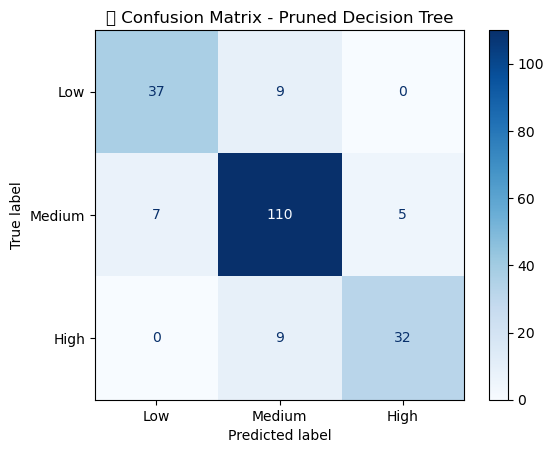

In [53]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pruned_tree_model.predict(X_test))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap="Blues", values_format="d")
plt.title("🔍 Confusion Matrix - Pruned Decision Tree")
plt.show()

C:\Users\mende\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


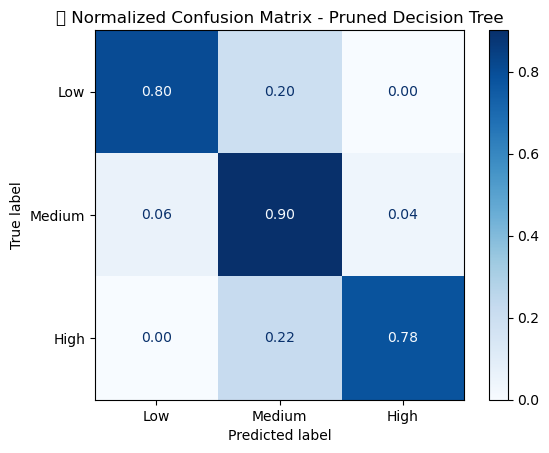

In [54]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (actual class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Low", "Medium", "High"])
disp.plot(cmap="Blues", values_format=".2f")  # Show percentages instead of counts
plt.title("🔍 Normalized Confusion Matrix - Pruned Decision Tree")
plt.show()

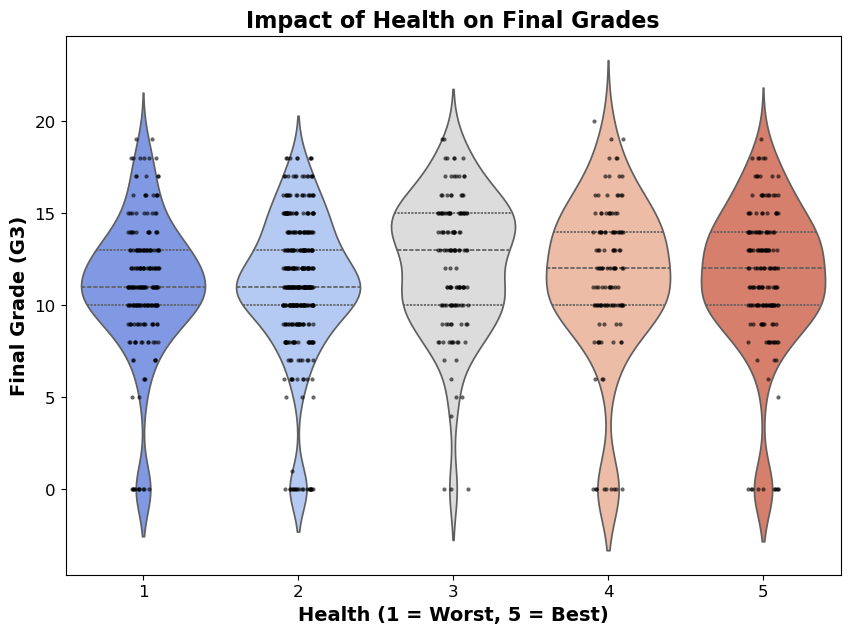

In [55]:
# Convert 'health' to categorical to ensure correct ordering
df["health"] = df["health"].astype(str)  

# Create figure with improved layout
plt.figure(figsize=(10, 7))

# Violin plot with proper hue assignment
sns.violinplot(x="health", y="G3", data=df, hue="health", dodge=False, inner="quartile", palette="coolwarm", legend=False)

# Strip plot for better visibility of individual points (alternative to swarmplot to avoid warnings)
sns.stripplot(x="health", y="G3", data=df, color="black", alpha=0.6, size=3, jitter=True)

# Set x-axis labels properly
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["1", "2", "3", "4", "5"], fontsize=12)
plt.yticks(fontsize=12)

# Formatting
plt.xlabel("Health (1 = Worst, 5 = Best)", fontsize=14, fontweight="bold")
plt.ylabel("Final Grade (G3)", fontsize=14, fontweight="bold")
plt.title("Impact of Health on Final Grades", fontsize=16, fontweight="bold")

# Show plot
plt.show()

C:\Users\mende\AppData\Local\Temp\ipykernel_25148\711250814.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="health", y="absences", data=df, inner="quartile", palette="coolwarm", alpha=0.8)
C:\Users\mende\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 19.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\mende\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 42.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\mende\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.wa

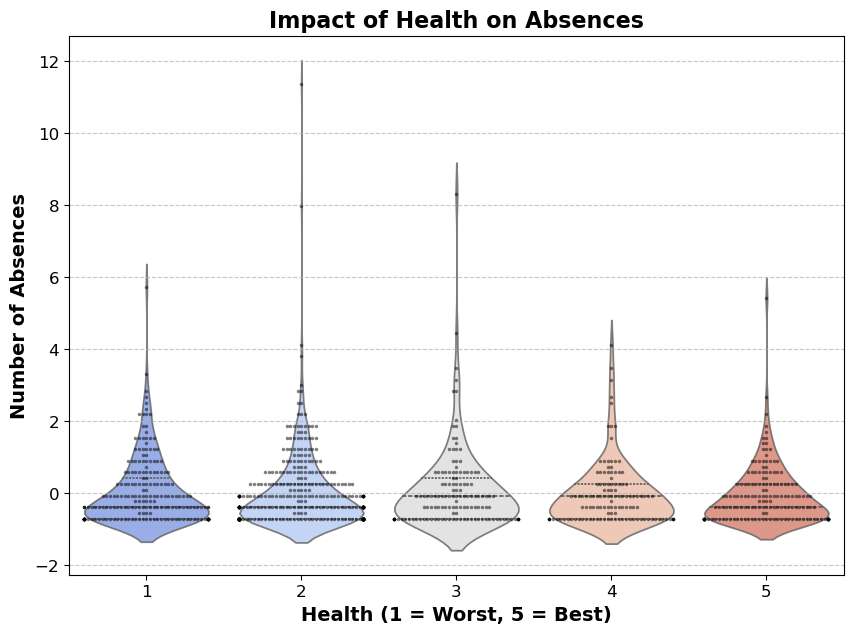

In [56]:
# Convert 'health' to categorical to ensure correct ordering
#df["health"] = df["health"].astype(str)

# Create figure with improved layout
plt.figure(figsize=(10, 7))

# Violin plot with correct formatting
sns.violinplot(x="health", y="absences", data=df, inner="quartile", palette="coolwarm", alpha=0.8)

# Swarmplot with reduced marker size to prevent overcrowding
sns.swarmplot(
    x="health", y="absences", data=df, color="black", alpha=0.5, 
    size=2.5  # Adjusted marker size to prevent warnings
)

# Ensure x-axis labels are formatted correctly
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["1", "2", "3", "4", "5"], fontsize=12)
plt.yticks(fontsize=12)

# Formatting
plt.xlabel("Health (1 = Worst, 5 = Best)", fontsize=14, fontweight="bold")
plt.ylabel("Number of Absences", fontsize=14, fontweight="bold")
plt.title("Impact of Health on Absences", fontsize=16, fontweight="bold")

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

C:\Users\mende\AppData\Local\Temp\ipykernel_25148\151556981.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["health"], y=df["famrel"], palette="coolwarm")


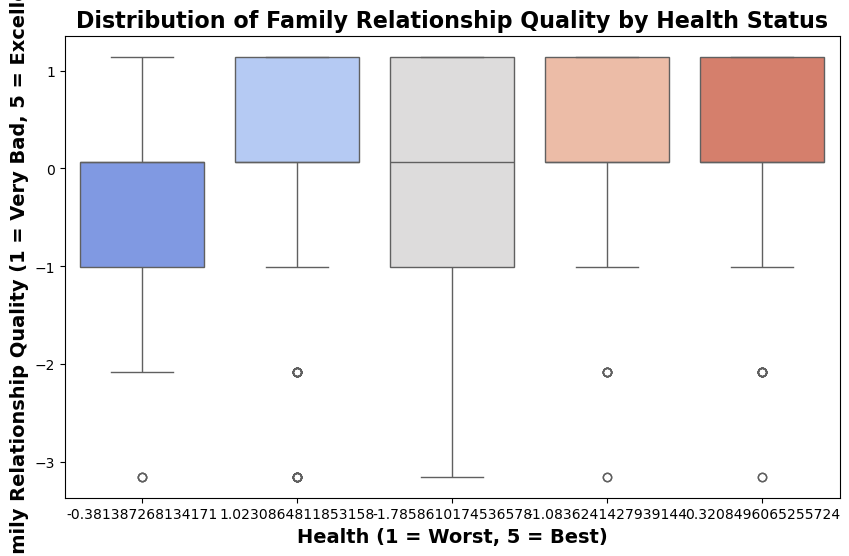

In [57]:
# Create the original boxplot for Health vs. Family Relationship Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["health"], y=df["famrel"], palette="coolwarm")

# Formatting
plt.xlabel("Health (1 = Worst, 5 = Best)", fontsize=14, fontweight="bold")
plt.ylabel("Family Relationship Quality (1 = Very Bad, 5 = Excellent)", fontsize=14, fontweight="bold")
plt.title("Distribution of Family Relationship Quality by Health Status", fontsize=16, fontweight="bold")

# Show plot
plt.show()

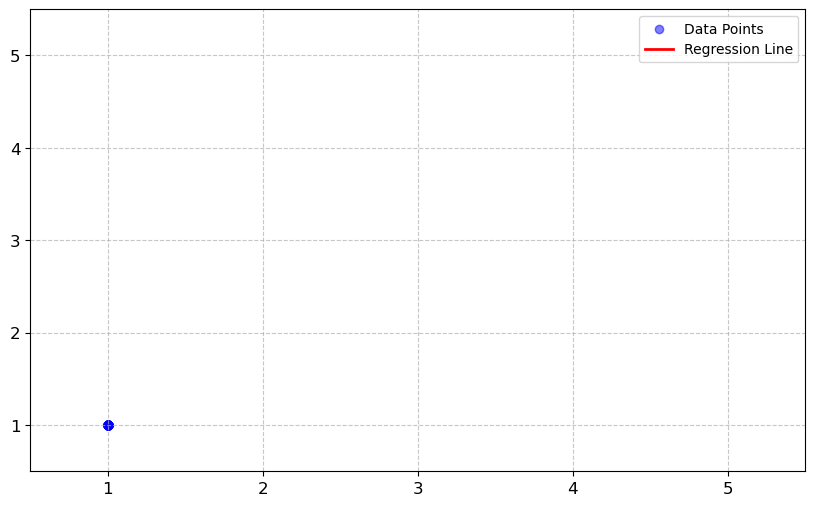

                            OLS Regression Results                            
Dep. Variable:                 famrel   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.802
Date:                Tue, 18 Mar 2025   Prob (F-statistic):            0.00308
Time:                        21:22:19   Log-Likelihood:                -1404.5
No. Observations:                1044   AIC:                             2813.
Df Residuals:                    1042   BIC:                             2823.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0783      0.029     -2.684      0.0

In [64]:
# Ensure health and famrel are numerical
df["health"] = pd.to_numeric(df["health"], errors="coerce").astype(int)
df["famrel"] = pd.to_numeric(df["famrel"], errors="coerce").astype(int)

# Drop any NaN values
df = df.dropna(subset=["health", "famrel"])

# Define independent (X) and dependent (Y) variables
X = sm.add_constant(df["health"])  # Adds an intercept term
Y = df["famrel"]

# Perform linear regression analysis
model = sm.OLS(Y, X).fit()

# Generate predicted values for the regression line
x_range = np.linspace(1, 5, 100)  # Explicitly setting the range to match health scale
y_pred = model.predict(sm.add_constant(x_range))

# Create the scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(df["health"], df["famrel"], alpha=0.5, color="blue", label="Data Points")
plt.plot(x_range, y_pred, color="red", linewidth=2, label="Regression Line")

# Formatting
plt.xlim(0.5, 5.5)  # Ensures x-axis covers the full health range
plt.ylim(0.5, 5.5)  # Ensures y-axis covers the full famrel range
plt.xticks([1, 2, 3, 4, 5], fontsize=12)
plt.yticks([1, 2, 3, 4, 5], fontsize=12)

# Add legend and grid
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# Show plot
plt.show()

# Print regression summary
print(model.summary())